In [16]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from random import shuffle
import matplotlib.pyplot as plt
import numpy as np
import os
from six.moves.urllib.request import urlretrieve
import tarfile
import math
import time

In [2]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

HORSE_CATEGORY = 7

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

 ship plane   cat   car


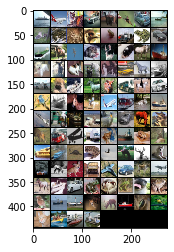

In [3]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
def load_subset(dataset, cls=HORSE_CATEGORY, transpose=False):
    ans = []
    for data in dataset:
        images, labels = data
        msk = labels == cls
        idx = np.nonzero(msk).squeeze()
        ans.append(torch.index_select(images, 0, idx))
    shuffle(ans)
    X = torch.cat(ans)
    if transpose:
        X = X.permute(0, 2, 3, 1)
    return X

In [5]:
def get_file(fname,
             origin,
             untar=False,
             extract=False,
             archive_format='auto',
             cache_dir='data'):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + '.tar.gz'
    else:
        fpath = os.path.join(datadir, fname)
    
    print(fpath)
    if not os.path.exists(fpath):
        print('Downloading data from', origin)

        error_msg = 'URL fetch failure on {}: {} -- {}'
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print('Extracting file.')
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath

In [6]:
######################################################################
# Download CIFAR datasets and other related files
######################################################################
colours_fpath = get_file(fname='colours', 
                         origin='http://www.cs.toronto.edu/~jba/kmeans_colour_a2.tar.gz', 
                         untar=True)

data/colours.tar.gz


In [7]:
######################################################################
# Data related code
######################################################################
def get_cat_rgb(cats, colours):
    """
    Get RGB colours given the colour categories

    Args:
      cats: integer numpy array of colour categories
      colours: numpy array of colour categories and their RGB values
    Returns:
      numpy tensor of RGB colours
    """
    return colours[cats]

def process(xs, max_pixel=256.0, downsize_input=False):
    """
    Pre-process CIFAR10 images by taking only the horse category,
    shuffling, and have colour values be bound between 0 and 1

    Args:
      xs: the colour RGB pixel values
      ys: the category labels
      max_pixel: maximum pixel value in the original data
    Returns:
      xs: value normalized and shuffled colour images
      grey: greyscale images, also normalized so values are between 0 and 1
    """
    grey = xs.mean(axis=1, keepdims=True)

    if downsize_input:
        downsize_module = nn.Sequential(nn.AvgPool2d(2),
                               nn.AvgPool2d(2), 
                               nn.Upsample(scale_factor=2, mode='bilinear'), 
                               nn.Upsample(scale_factor=2, mode='bilinear'))
        xs_downsized = downsize_module.forward(xs)
        xs_downsized = xs_downsized.detach()
        return (xs, xs_downsized)
    else:
        return (xs, grey)


def get_batch(x, y, batch_size):
    '''
    Generated that yields batches of data

    Args:
      x: input values
      y: output values
      batch_size: size of each batch
    Yields:
      batch_x: a batch of inputs of size at most batch_size
      batch_y: a batch of outputs of size at most batch_size
    '''
    N = x.size(0)
    assert N == y.size(0)
    for i in range(0, N, batch_size):
        batch_x = x[i:i+batch_size, :,:,:]
        batch_y = y[i:i+batch_size, :,:,:]
        yield (batch_x, batch_y)

# Visualization

In [8]:
def plot(input, gtlabel, output, colours, path, visualize):
    """
    Generate png plots of input, ground truth, and outputs

    Args:
      input: the greyscale input to the colourization CNN
      gtlabel: the grouth truth categories for each pixel
      output: the predicted categories for each pixel
      colours: numpy array of colour categories and their RGB values
      path: output path
    """
    k = 10
    grey = input[:k,:,:,:].permute(0,2,3,1).numpy()
    if colours is None:
        gtcolor = gtlabel[:k,:,:,:].permute(0, 2, 3, 1).numpy()
        predcolor = output[:k,:,:,:].permute(0, 2, 3, 1).numpy()
    else:
        gtcolor = get_cat_rgb(gtlabel[:k,0,:,:], colours).numpy()
        predcolor = get_cat_rgb(output[:k,0,:,:], colours).numpy()

    img = np.vstack([
      np.hstack(np.tile(grey, [1,1,1,3])),
      np.hstack(gtcolor),
      np.hstack(predcolor)])
    #plt.figure()
    plt.grid('off')
    plt.imshow(img, vmin=0., vmax=1.)
    if visualize:
        plt.show()
    else:
        plt.savefig(path)

# Regression network

In [9]:
class MyConv2d(nn.Module):
    """
    Our simplified implemented of nn.Conv2d module for 2D convolution
    """
    def __init__(self, in_channels, out_channels, kernel_size, padding=None):
        super(MyConv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        if padding is None:
            self.padding = kernel_size // 2
        else:
            self.padding = padding
        self.weight = nn.parameter.Parameter(torch.Tensor(
            out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.parameter.Parameter(torch.Tensor(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels * self.kernel_size * self.kernel_size
        stdv = 1. / math.sqrt(n)
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        return F.conv2d(input, self.weight, self.bias, padding=self.padding)

In [10]:
class RegressionCNN(nn.Module):
    def __init__(self, kernel, num_filters):
        # first call parent's initialization function
        super(RegressionCNN, self).__init__()
        padding = kernel // 2

        self.downconv1 = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.upconv2 = nn.Sequential(
            nn.Conv2d(num_filters, 3, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.finalconv = MyConv2d(3, 3, kernel_size=kernel)

    def forward(self, x):
        out = self.downconv1(x)
        out = self.downconv2(out)
        out = self.rfconv(out)
        out = self.upconv1(out)
        out = self.upconv2(out)
        out = self.finalconv(out)
        return out

In [11]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

# Training

In [13]:
def train(args, cnn=None):
    # Set the maximum number of threads to prevent crash in Teaching Labs
    torch.set_num_threads(5)
    # Numpy random seed
    torch.manual_seed(args.seed)
    
    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE MODEL
    if cnn is None:
        cnn = RegressionCNN(args.kernel, args.num_filters)

    # Set up L2 loss
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=args.learn_rate)
    

    # Loading & transforming data
    print("Loading data...")
    x_train = load_subset(trainloader)
    x_test = load_subset(testloader)
    train_rgb, train_grey = process(x_train)
    test_rgb, test_grey = process(x_test)


    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    cnn.to(device)
    start = time.time()

    for epoch in range(args.epochs):
        # Train the Model
        cnn.train() # Change model to 'train' mode
        for xs, ys in get_batch(train_grey, train_rgb, args.batch_size):
            images, labels = xs.to(device), ys.to(device)
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = cnn(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
        print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, args.epochs, loss.item()))

        # Evaluate the model
        cnn.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
        losses = []
        with torch.no_grad():
            for xs, ys in get_batch(test_grey, test_rgb, args.batch_size):
                images, labels = xs.to(device), ys.to(device)
                outputs = cnn(images)

                val_loss = criterion(outputs, labels)
                losses.append(val_loss.item())

        val_loss = np.mean(losses)
        print('Epoch [%d/%d], Val Loss: %.4f' % (epoch+1, args.epochs, val_loss))

    print("Generating predictions...")
    plot(xs, ys, outputs.cpu().detach(), colours=None, 
             path=save_dir+"/regression_output.png", visualize=args.visualize)
    
    if args.checkpoint:
        print('Saving model...')
        torch.save(cnn.state_dict(), args.checkpoint)
    
    return cnn

Loading data...
Beginning training ...
Epoch [1/25], Loss: 0.0880
Epoch [1/25], Val Loss: 0.0925
Epoch [2/25], Loss: 0.0308
Epoch [2/25], Val Loss: 0.0349
Epoch [3/25], Loss: 0.0212
Epoch [3/25], Val Loss: 0.0230
Epoch [4/25], Loss: 0.0184
Epoch [4/25], Val Loss: 0.0186
Epoch [5/25], Loss: 0.0170
Epoch [5/25], Val Loss: 0.0172
Epoch [6/25], Loss: 0.0157
Epoch [6/25], Val Loss: 0.0162
Epoch [7/25], Loss: 0.0148
Epoch [7/25], Val Loss: 0.0152
Epoch [8/25], Loss: 0.0140
Epoch [8/25], Val Loss: 0.0144
Epoch [9/25], Loss: 0.0134
Epoch [9/25], Val Loss: 0.0136
Epoch [10/25], Loss: 0.0129
Epoch [10/25], Val Loss: 0.0130
Epoch [11/25], Loss: 0.0125
Epoch [11/25], Val Loss: 0.0126
Epoch [12/25], Loss: 0.0121
Epoch [12/25], Val Loss: 0.0122
Epoch [13/25], Loss: 0.0117
Epoch [13/25], Val Loss: 0.0118
Epoch [14/25], Loss: 0.0114
Epoch [14/25], Val Loss: 0.0115
Epoch [15/25], Loss: 0.0111
Epoch [15/25], Val Loss: 0.0112
Epoch [16/25], Loss: 0.0109
Epoch [16/25], Val Loss: 0.0110
Epoch [17/25], Loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [25/25], Val Loss: 0.0096
Generating predictions...


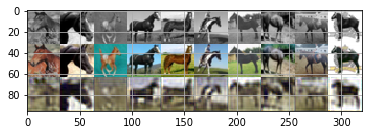

In [14]:
args = AttrDict()
args_dict = {
              'valid':False, 
              'checkpoint':"", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.001, 
              'batch_size':100, 
              'epochs':25, 
              'seed':20200207,
              'plot':True, 
              'experiment_name': 'regression_cnn',
              'visualize': False,
              'downsize_input':False,
}
args.update(args_dict)
cnn = train(args)